In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pytrends.request import TrendReq


In [5]:
# Fetch "gold" trends data
pytrends = TrendReq(hl='en-US', tz=360)

pytrends.build_payload(kw_list=["gold"], timeframe="2024-05-18 2024-11-18")
gold_trends = pytrends.interest_over_time()
if "isPartial" in gold_trends.columns:
    gold_trends = gold_trends.drop(columns=["isPartial"])

# Fetch "gold etf" trends data
pytrends.build_payload(kw_list=["gold etf"], timeframe="2024-05-18 2024-11-18")
gold_etf_trends = pytrends.interest_over_time()
if "isPartial" in gold_etf_trends.columns:
    gold_etf_trends = gold_etf_trends.drop(columns=["isPartial"])

# Rename columns to avoid conflicts
gold_trends.rename(columns={"gold": "gold_trend"}, inplace=True)
gold_etf_trends.rename(columns={"gold etf": "gold_etf_trend"}, inplace=True)

# Display both data sets
print("Gold Trends:\n", gold_trends.head())
print("Gold ETF Trends:\n", gold_etf_trends.head())


Gold Trends:
             gold_trend
date                  
2024-05-18          57
2024-05-19          53
2024-05-20          59
2024-05-21          57
2024-05-22          56
Gold ETF Trends:
             gold_etf_trend
date                      
2024-05-18              20
2024-05-19              16
2024-05-20              26
2024-05-21              31
2024-05-22              25


In [6]:
# Merge the trends data on the index
google_trends_combined = pd.merge(
    gold_trends, gold_etf_trends, left_index=True, right_index=True, how="inner"
)

# Display the combined data
print("Combined Google Trends Data:\n", google_trends_combined.head())


Combined Google Trends Data:
             gold_trend  gold_etf_trend
date                                  
2024-05-18          57              20
2024-05-19          53              16
2024-05-20          59              26
2024-05-21          57              31
2024-05-22          56              25


In [7]:
# Calculate momentum for each trend
google_trends_combined["gold_momentum"] = google_trends_combined["gold_trend"].diff()
google_trends_combined["gold_etf_momentum"] = google_trends_combined["gold_etf_trend"].diff()

# Define thresholds for signals
momentum_threshold_buy = 5
momentum_threshold_sell = -5

# Initialize combined signal column
google_trends_combined["signal"] = 0

# Generate signals for "gold"
google_trends_combined.loc[
    google_trends_combined["gold_momentum"] > momentum_threshold_buy, "signal"
] += 1
google_trends_combined.loc[
    google_trends_combined["gold_momentum"] < momentum_threshold_sell, "signal"
] -= 1

# Generate signals for "gold etf"
google_trends_combined.loc[
    google_trends_combined["gold_etf_momentum"] > momentum_threshold_buy, "signal"
] += 1
google_trends_combined.loc[
    google_trends_combined["gold_etf_momentum"] < momentum_threshold_sell, "signal"
] -= 1

# Shift signals to avoid lookahead bias
google_trends_combined["signal"] = google_trends_combined["signal"].shift(1)

# Display signals
print("Google Trends Combined with Signals:\n", google_trends_combined.tail())


Google Trends Combined with Signals:
             gold_trend  gold_etf_trend  gold_momentum  gold_etf_momentum  \
date                                                                       
2024-11-14          77              49            4.0               -2.0   
2024-11-15          78              36            1.0              -13.0   
2024-11-16          77              30           -1.0               -6.0   
2024-11-17          76              29           -1.0               -1.0   
2024-11-18          75              49           -1.0               20.0   

            signal  
date                
2024-11-14     0.0  
2024-11-15     0.0  
2024-11-16    -1.0  
2024-11-17    -1.0  
2024-11-18     0.0  


In [8]:
# Fetch Gold ETF prices
gold_prices = yf.download("GLD", start="2024-05-18", end="2024-11-18")

# Calculate daily returns
gold_prices["Returns"] = gold_prices["Adj Close"].pct_change()

# Display fetched prices
print("Gold ETF Prices:\n", gold_prices.head())


[*********************100%***********************]  1 of 1 completed

Gold ETF Prices:
 Price                       Adj Close       Close        High         Low  \
Ticker                            GLD         GLD         GLD         GLD   
Date                                                                        
2024-05-20 00:00:00+00:00  224.559998  224.559998  225.660004  223.020004   
2024-05-21 00:00:00+00:00  224.229996  224.229996  225.210007  223.699997   
2024-05-22 00:00:00+00:00  220.110001  220.110001  223.240005  219.740005   
2024-05-23 00:00:00+00:00  215.720001  215.720001  219.229996  215.660004   
2024-05-24 00:00:00+00:00  215.919998  215.919998  217.210007  215.740005   

Price                            Open   Volume   Returns  
Ticker                            GLD      GLD            
Date                                                      
2024-05-20 00:00:00+00:00  223.789993  5990900       NaN  
2024-05-21 00:00:00+00:00  224.770004  4002600 -0.001470  
2024-05-22 00:00:00+00:00  223.089996  8903100 -0.018374  
2024-05-23 

In [9]:
# Remove timezone from indices
gold_prices.index = gold_prices.index.tz_localize(None)
google_trends_combined.index = google_trends_combined.index.tz_localize(None)

# Align signals with Gold ETF prices
gold_prices["signal"] = google_trends_combined["signal"].reindex(
    gold_prices.index, method="ffill"
).fillna(0)

# Display aligned data
print("Aligned Data:\n", gold_prices[["Adj Close", "Returns", "signal"]].head())


Aligned Data:
 Price        Adj Close   Returns signal
Ticker             GLD                 
Date                                   
2024-05-20  224.559998       NaN    0.0
2024-05-21  224.229996 -0.001470    2.0
2024-05-22  220.110001 -0.018374    0.0
2024-05-23  215.720001 -0.019945   -1.0
2024-05-24  215.919998  0.000927    0.0


In [10]:
# Function to calculate RSI
def calculate_rsi(prices, window):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to calculate MACD
def calculate_macd(prices, short_window, long_window, signal_window):
    short_ema = prices.ewm(span=short_window, adjust=False).mean()
    long_ema = prices.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

# Define thresholds to test
rsi_thresholds = [(25, 75), (20, 80), (30, 70)]
macd_windows = [(10, 21, 7), (12, 26, 9), (14, 30, 10)]
ema_windows = [(10, 50), (12, 26), (20, 50)]

# Backtest for each combination of thresholds
results = []

for rsi_lower, rsi_upper in rsi_thresholds:
    for short_window, long_window, signal_window in macd_windows:
        for short_ema, long_ema in ema_windows:
            # Add RSI
            gold_prices["RSI"] = calculate_rsi(gold_prices["Adj Close"], window=14)
            gold_prices["RSI Signal"] = 0
            gold_prices.loc[gold_prices["RSI"] < rsi_lower, "RSI Signal"] = 1
            gold_prices.loc[gold_prices["RSI"] > rsi_upper, "RSI Signal"] = -1

            # Add MACD
            gold_prices["MACD"], gold_prices["MACD Signal"] = calculate_macd(
                gold_prices["Adj Close"], short_window, long_window, signal_window
            )
            gold_prices["MACD Signal"] = 0
            gold_prices.loc[gold_prices["MACD"] > gold_prices["MACD Signal"], "MACD Signal"] = 1
            gold_prices.loc[gold_prices["MACD"] < gold_prices["MACD Signal"], "MACD Signal"] = -1

            # Add EMA crossover signals
            gold_prices["Short EMA"] = gold_prices["Adj Close"].ewm(span=short_ema, adjust=False).mean()
            gold_prices["Long EMA"] = gold_prices["Adj Close"].ewm(span=long_ema, adjust=False).mean()
            gold_prices["EMA Signal"] = 0
            gold_prices.loc[gold_prices["Short EMA"] > gold_prices["Long EMA"], "EMA Signal"] = 1
            gold_prices.loc[gold_prices["Short EMA"] < gold_prices["Long EMA"], "EMA Signal"] = -1

            # Combine signals
            gold_prices["Combined Signal"] = (
                gold_prices["RSI Signal"]
                + gold_prices["MACD Signal"]
                + gold_prices["EMA Signal"]
            )

            # Calculate strategy returns
            gold_prices["Strategy Returns"] = (
                gold_prices["Returns"] * gold_prices["Combined Signal"].shift(1)
            )

            # Calculate cumulative returns
            gold_prices["Cumulative Strategy"] = (1 + gold_prices["Strategy Returns"]).cumprod()

            # Evaluate strategy
            sharpe_ratio = gold_prices["Strategy Returns"].mean() / gold_prices["Strategy Returns"].std() * (252 ** 0.5)
            final_value = 1000 * gold_prices["Cumulative Strategy"].iloc[-1]

            results.append(
                {
                    "RSI Thresholds": (rsi_lower, rsi_upper),
                    "MACD Windows": (short_window, long_window, signal_window),
                    "EMA Windows": (short_ema, long_ema),
                    "Sharpe Ratio": sharpe_ratio,
                    "Final Portfolio Value": final_value,
                }
            )

# Convert results to a DataFrame and display the best-performing thresholds
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Sharpe Ratio", ascending=False)
results_df.head()


/var/folders/2v/418w7x5d03g34d38xmfssx8h0000gn/T/ipykernel_10843/1083930922.py:65: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = gold_prices["Strategy Returns"].mean() / gold_prices["Strategy Returns"].std() * (252 ** 0.5)
/var/folders/2v/418w7x5d03g34d38xmfssx8h0000gn/T/ipykernel_10843/1083930922.py:65: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = gold_prices["Strategy Returns"].mean() / gold_prices["Strategy Returns"].std() * (252 ** 0.5)
/var/folders/2v/418w7x5d03g34d38xmfssx8h0000gn/T/ipykernel_10843/1083930922.py:65: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = gold_prices["Strategy Returns"].mean() / gold_prices["Strategy Returns"].std() * (252 ** 0.5)
/var/folders/2v/418w7x5d03g34d38xmfssx8h0000gn/T/ipykernel_10843/1083930922.py:65: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = gold_prices["Strategy Returns"].mean() / gold_prices["Strategy Returns"].std() * (

,RSI Thresholds,MACD Windows,EMA Windows,Sharpe Ratio,Final Portfolio Value
0,"(25, 75)","(10, 21, 7)","(10, 50)",0.647912,1074.506419
1,"(25, 75)","(10, 21, 7)","(12, 26)",NaN,1000.000000
2,"(25, 75)","(10, 21, 7)","(20, 50)",NaN,1000.000000
3,"(25, 75)","(12, 26, 9)","(10, 50)",NaN,1000.000000
4,"(25, 75)","(12, 26, 9)","(12, 26)",NaN,1000.000000


Sharpe Ratio (Buy & Hold): 0.74
Sharpe Ratio (Enhanced Strategy): 1.2
Final Value of $1,000 (Buy & Hold): $ 1053.57
Final Value of $1,000 (Enhanced Strategy): $ 1077.98

Cumulative Returns (Last 5 Days):
 Price      Cumulative Buy & Hold (%) Cumulative Strategy (%)
Ticker                                                      
Date                                                        
2024-11-11                  7.828644                7.933376
2024-11-12                  6.897936                7.001765
2024-11-13                  5.820274                8.080474
2024-11-14                  5.544174                7.798477
2024-11-15                  5.357142                7.798477


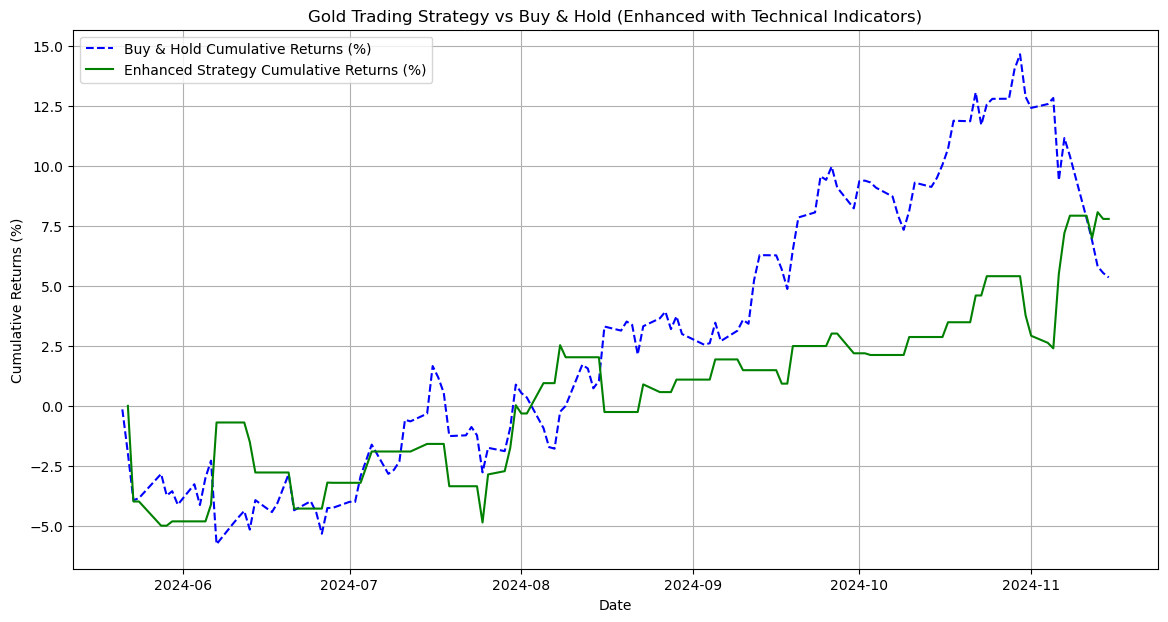

Enhanced CSV file with portfolio values saved to: enhanced_portfolio_value_comparison.csv


In [11]:
import numpy as np

# Shift the signal to ensure alignment with the next trading day
gold_prices["signal"] = gold_prices["signal"].shift(1)

# Add RSI calculation
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

gold_prices["RSI"] = calculate_rsi(gold_prices["Adj Close"])

# Add MACD calculation
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    short_ema = prices.ewm(span=short_window, adjust=False).mean()
    long_ema = prices.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

gold_prices["MACD"], gold_prices["MACD Signal"] = calculate_macd(gold_prices["Adj Close"])

# Add EMA Crossover
gold_prices["Short EMA"] = gold_prices["Adj Close"].ewm(span=12, adjust=False).mean()
gold_prices["Long EMA"] = gold_prices["Adj Close"].ewm(span=26, adjust=False).mean()

# Generate technical signals
gold_prices["Tech Signal"] = 0
gold_prices.loc[gold_prices["RSI"] < 25, "Tech Signal"] = 1  # RSI Buy
gold_prices.loc[gold_prices["RSI"] > 75, "Tech Signal"] = -1  # RSI Sell

gold_prices.loc[gold_prices["MACD"] > gold_prices["MACD Signal"], "Tech Signal"] = 1  # MACD Buy
gold_prices.loc[gold_prices["MACD"] < gold_prices["MACD Signal"], "Tech Signal"] = -1  # MACD Sell

gold_prices.loc[gold_prices["Short EMA"] > gold_prices["Long EMA"], "Tech Signal"] = 1  # EMA Buy
gold_prices.loc[gold_prices["Short EMA"] < gold_prices["Long EMA"], "Tech Signal"] = -1  # EMA Sell

# Combine Google Trends signals with technical signals
gold_prices["Combined Signal"] = gold_prices["signal"] + gold_prices["Tech Signal"]

# Calculate strategy returns based on combined signals
gold_prices["Strategy Returns"] = gold_prices["Returns"] * gold_prices["Combined Signal"].shift(1)

# Recalculate cumulative returns
gold_prices["Cumulative Buy & Hold"] = (1 + gold_prices["Returns"]).cumprod()
gold_prices["Cumulative Strategy"] = (1 + gold_prices["Strategy Returns"]).cumprod()

# Convert cumulative returns to percentages
gold_prices["Cumulative Buy & Hold (%)"] = (gold_prices["Cumulative Buy & Hold"] - 1) * 100
gold_prices["Cumulative Strategy (%)"] = (gold_prices["Cumulative Strategy"] - 1) * 100

# Calculate Sharpe Ratios (Annualized)
sharpe_buy_hold = (gold_prices["Returns"].mean() / gold_prices["Returns"].std()) * (252 ** 0.5)
sharpe_strategy = (gold_prices["Strategy Returns"].mean() / gold_prices["Strategy Returns"].std()) * (252 ** 0.5)

# Calculate the final value of a $1,000 investment for both strategies
final_buy_hold = 1000 * gold_prices["Cumulative Buy & Hold"].iloc[-1]
final_strategy = 1000 * gold_prices["Cumulative Strategy"].iloc[-1]

# Add columns to track $1,000 portfolio value over time
gold_prices["Portfolio Value (Buy & Hold)"] = 1000 * gold_prices["Cumulative Buy & Hold"]
gold_prices["Portfolio Value (Strategy)"] = 1000 * gold_prices["Cumulative Strategy"]

# Display corrected key statistics
print("Sharpe Ratio (Buy & Hold):", round(sharpe_buy_hold, 2))
print("Sharpe Ratio (Enhanced Strategy):", round(sharpe_strategy, 2))
print("Final Value of $1,000 (Buy & Hold): $", round(final_buy_hold, 2))
print("Final Value of $1,000 (Enhanced Strategy): $", round(final_strategy, 2))

# Display cumulative returns (last 5 days as a sample)
print("\nCumulative Returns (Last 5 Days):\n", 
      gold_prices[["Cumulative Buy & Hold (%)", "Cumulative Strategy (%)"]].tail())

# Plot cumulative returns for both strategies
plt.figure(figsize=(14, 7))
plt.plot(gold_prices["Cumulative Buy & Hold (%)"], label="Buy & Hold Cumulative Returns (%)", linestyle="--", color="blue")
plt.plot(gold_prices["Cumulative Strategy (%)"], label="Enhanced Strategy Cumulative Returns (%)", linestyle="-", color="green")
plt.title("Gold Trading Strategy vs Buy & Hold (Enhanced with Technical Indicators)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.legend()
plt.grid(True)
plt.show()

# Export enhanced data to a CSV file
enhanced_output_csv_path = "enhanced_portfolio_value_comparison.csv"
gold_prices[[
    "Adj Close", 
    "Returns", 
    "signal", 
    "Tech Signal", 
    "Combined Signal", 
    "Portfolio Value (Buy & Hold)", 
    "Portfolio Value (Strategy)"
]].to_csv(enhanced_output_csv_path)

print("Enhanced CSV file with portfolio values saved to:", enhanced_output_csv_path)


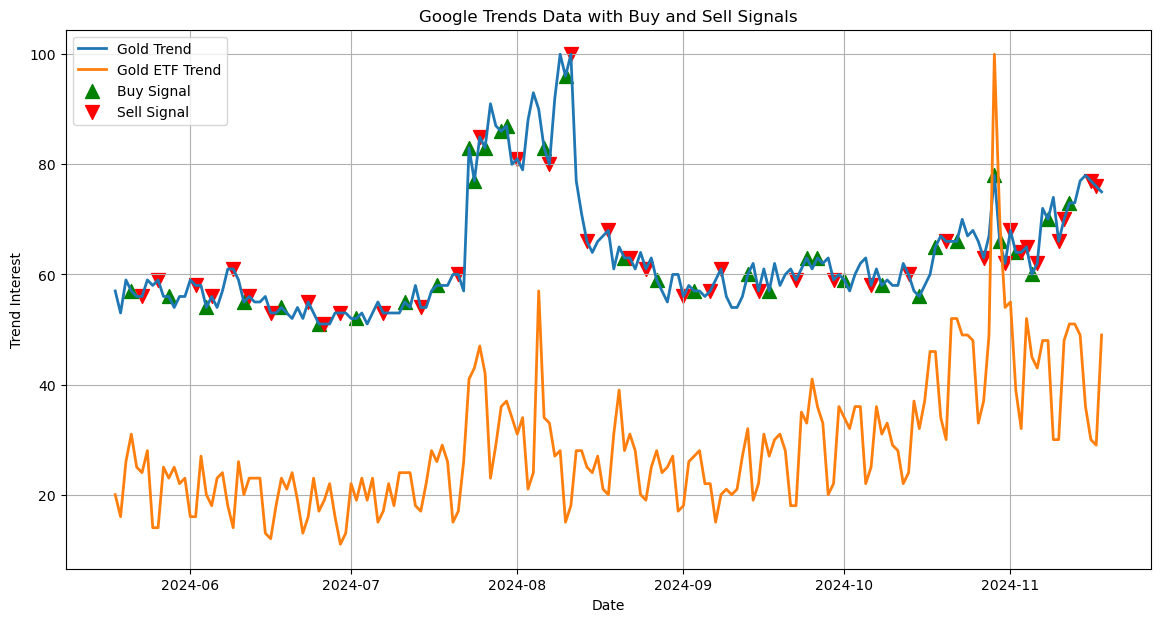

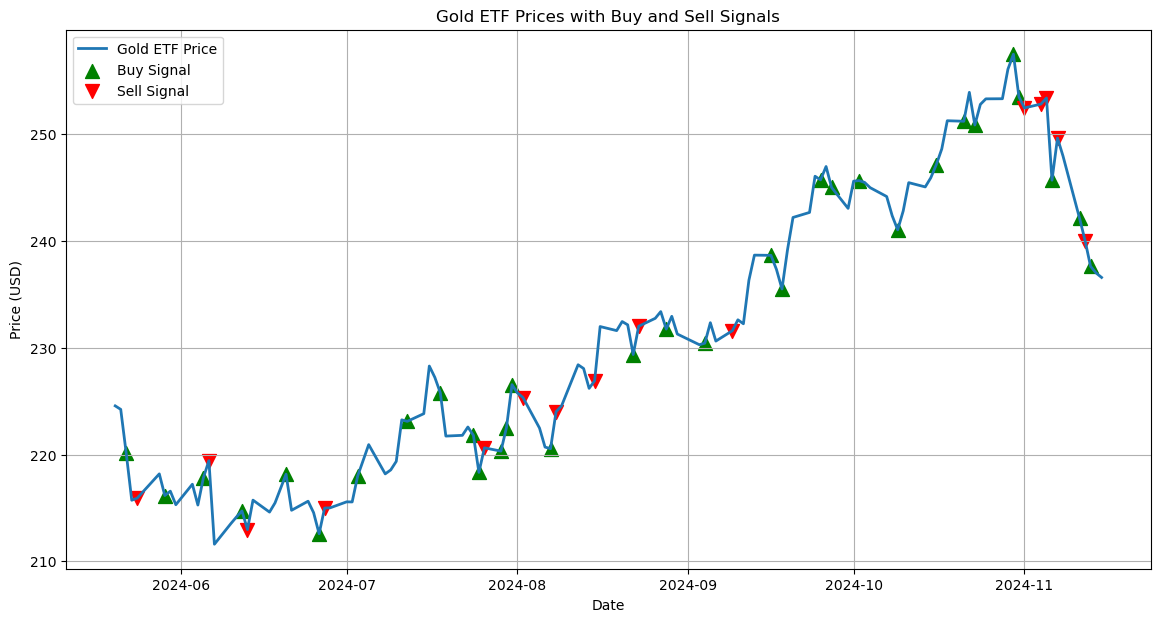

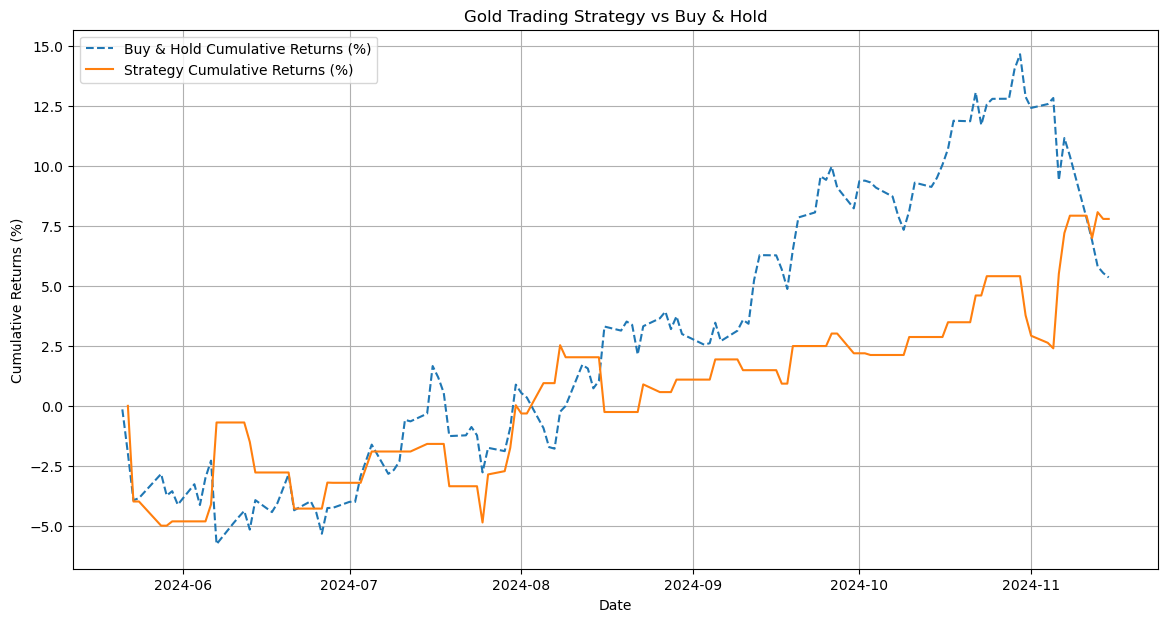

In [12]:
# Plot buy and sell signals on Google Trends data
plt.figure(figsize=(14, 7))

# Plot the Google Trends data
plt.plot(google_trends_combined["gold_trend"], label="Gold Trend", linewidth=2)
plt.plot(google_trends_combined["gold_etf_trend"], label="Gold ETF Trend", linewidth=2)

# Highlight buy signals
buy_signals = google_trends_combined[google_trends_combined["signal"] > 0]
sell_signals = google_trends_combined[google_trends_combined["signal"] < 0]

plt.scatter(buy_signals.index, buy_signals["gold_trend"], color="green", label="Buy Signal", marker="^", s=100)
plt.scatter(sell_signals.index, sell_signals["gold_trend"], color="red", label="Sell Signal", marker="v", s=100)

plt.title("Google Trends Data with Buy and Sell Signals")
plt.xlabel("Date")
plt.ylabel("Trend Interest")
plt.legend()
plt.grid(True)
plt.show()

# Plot Gold ETF Prices with Buy/Sell Signals
plt.figure(figsize=(14, 7))

# Plot Gold ETF prices
plt.plot(gold_prices["Adj Close"], label="Gold ETF Price", linewidth=2)

# Highlight buy/sell signals on ETF prices
buy_signals_etf = gold_prices[gold_prices["signal"] > 0]
sell_signals_etf = gold_prices[gold_prices["signal"] < 0]

plt.scatter(buy_signals_etf.index, buy_signals_etf["Adj Close"], color="green", label="Buy Signal", marker="^", s=100)
plt.scatter(sell_signals_etf.index, sell_signals_etf["Adj Close"], color="red", label="Sell Signal", marker="v", s=100)

plt.title("Gold ETF Prices with Buy and Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Cumulative Returns
plt.figure(figsize=(14, 7))
plt.plot(gold_prices["Cumulative Buy & Hold (%)"], label="Buy & Hold Cumulative Returns (%)", linestyle="--")
plt.plot(gold_prices["Cumulative Strategy (%)"], label="Strategy Cumulative Returns (%)", linestyle="-")
plt.title("Gold Trading Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Step 6: Save Data to CSV
combined_data = gold_prices.copy()
combined_data["gold_trend"] = google_trends_combined["gold_trend"].reindex(gold_prices.index, method="ffill")
combined_data["gold_etf_trend"] = google_trends_combined["gold_etf_trend"].reindex(gold_prices.index, method="ffill")
combined_data["gold_momentum"] = google_trends_combined["gold_momentum"].reindex(gold_prices.index, method="ffill")
combined_data["gold_etf_momentum"] = google_trends_combined["gold_etf_momentum"].reindex(gold_prices.index, method="ffill")

# Save to CSV
csv_file_path = "gold_trading_strategy_data.csv"
combined_data.to_csv(csv_file_path)

print("CSV file saved to:", csv_file_path)

CSV file saved to: gold_trading_strategy_data.csv
